<a href="https://colab.research.google.com/github/shonnvs-code/Team4-A1-BA820-Project/blob/main/BA820_TEAM4_European_Drug_Development_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **European Drug Development dataset**

# **1.1 Motivation**
The European Medicines Agency (EMA) datasets appeal to our team because they allow us to examine regulation both as a discrete approval event and as an evolving process. The drugs.csv file offers a structured overview of centrally authorized medicines and their key approval characteristics, including specialized pathways like orphan designation, conditional marketing authorization and additional monitoring, all formally defined within the EMA's regulatory architecture. We are particularly interested in examining how these approval features and therapeutic contexts tend to group together, and whether specific medicine profiles correlate systematically with greater subsequent oversight or recognizable regulatory patterns.

This project moves beyond average approval outcomes to understand any structural differences and how approval characteristics relate to downstream regulatory complexity, with the goal of informing regulators, pharmaceutical firms, and policymakers about where uncertainty and oversight are most concentrated.

# **1.2 Data Cleanup**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
from google.colab import data_table
from google.colab import drive
data_table.enable_dataframe_formatter()
drive.mount('/content/drive')

# Re-load the files (as final was not defined)
drugs = pd.read_csv('/content/drive/MyDrive/drugs.csv')
medicines_raw = pd.read_excel('/content/drive/MyDrive/Medicines_output_european_public_assessment_reports.xlsx',
                        header=None)

# Re-cleaning the Medicines File
medicines_clean = medicines_raw.dropna(how="all")
medicines_clean = medicines_clean.reset_index(drop=True)
medicines_clean = medicines_clean.rename(columns={
    0: "medicine_name_raw"
})
medicines_clean = medicines_clean[
    ~medicines_clean["medicine_name_raw"].str.contains(
        "European|assessment|generated|http|www|Tel",
        case=False,
        na=False
    )
]

# Re-joining the 2 files and creating 'final'
def normalize_name(x):
    if pd.isna(x):
        return None
    return (
        str(x)
        .lower()
        .strip()
        .replace(",", "")
    )

medicines_clean["medicine_key"] = medicines_clean["medicine_name_raw"].apply(normalize_name)
drugs["medicine_key"] = drugs["medicine_name"].apply(normalize_name)

merged = pd.merge(
    drugs,
    medicines_clean,
    on="medicine_key",
    how="outer"
)

merged["medicine_name_unified"] = (
    merged["medicine_name"]
    .combine_first(merged["medicine_name_raw"])
)
final = merged.drop(columns=["medicine_key", "medicine_name_raw"])

# Re-applying cleaning steps for 'final'
final = final.dropna(subset=["medicine_name_unified"])
final = final.drop_duplicates(subset=['medicine_name_unified'])




Mounted at /content/drive


In [ ]:
print(f"Number of duplicate entries in 'drugs[medicine_name]': {drugs['medicine_name'].duplicated().sum()}")
print(f"Number of null values in 'drugs[medicine_name]': {drugs['medicine_name'].isna().sum()}")
print(f"Number of duplicate entries in 'medicines_clean[medicine_name_raw]': {medicines_clean['medicine_name_raw'].duplicated().sum()}")
print(f"Number of null values in 'medicines_clean[medicine_name_raw]': {medicines_clean['medicine_name_raw'].isna().sum()}")

Number of duplicate entries in 'drugs[medicine_name]': 12
Number of null values in 'drugs[medicine_name]': 0
Number of duplicate entries in 'medicines_clean[medicine_name_raw]': 1989
Number of null values in 'medicines_clean[medicine_name_raw]': 4


In [ ]:
final = final.dropna(subset=["medicine_name_unified"])

print(f"Shape of final DataFrame after dropping nulls in 'medicine_name_unified': {final.shape}")
print(f"Null values in 'medicine_name_unified' after cleaning: {final['medicine_name_unified'].isna().sum()}")

Shape of final DataFrame after dropping nulls in 'medicine_name_unified': (1980, 58)
Null values in 'medicine_name_unified' after cleaning: 0


In [ ]:
final = final.drop_duplicates(subset=['medicine_name_unified'])

print(f"Shape of final DataFrame after deduplication: {final.shape}")
print("\nFirst 5 rows of the cleaned final DataFrame:")
data_table.DataTable(final.head())

Shape of final DataFrame after deduplication: (1980, 58)

First 5 rows of the cleaned final DataFrame:


,category,medicine_name,therapeutic_area,common_name,active_substance,product_number,patient_safety,authorisation_status,atc_code,additional_monitoring,...,21,22,23,24,25,26,27,28,29,medicine_name_unified
0,human,Abasaglar (previously Abasria),Diabetes Mellitus,insulin glargine,insulin glargine,2835.0,False,authorised,A10AE04,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abasaglar (previously Abasria)
1,human,Abecma,Multiple Myeloma; Neoplasms; Cancer; Neopla...,idecabtagene vicleucel,idecabtagene vicleucel,4662.0,False,authorised,L01,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abecma
2,human,Abevmy,Colorectal Neoplasms; Breast Neoplasms; Ovar...,bevacizumab,bevacizumab,5327.0,False,authorised,L01XC07,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abevmy
3,human,Abilify,Schizophrenia; Bipolar Disorder,aripiprazole,aripiprazole,471.0,False,authorised,N05AX12,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abilify
4,human,Abilify Maintena,Schizophrenia,aripiprazole,aripiprazole,2755.0,False,authorised,N05AX12,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abilify Maintena


# **1.3 EDA**

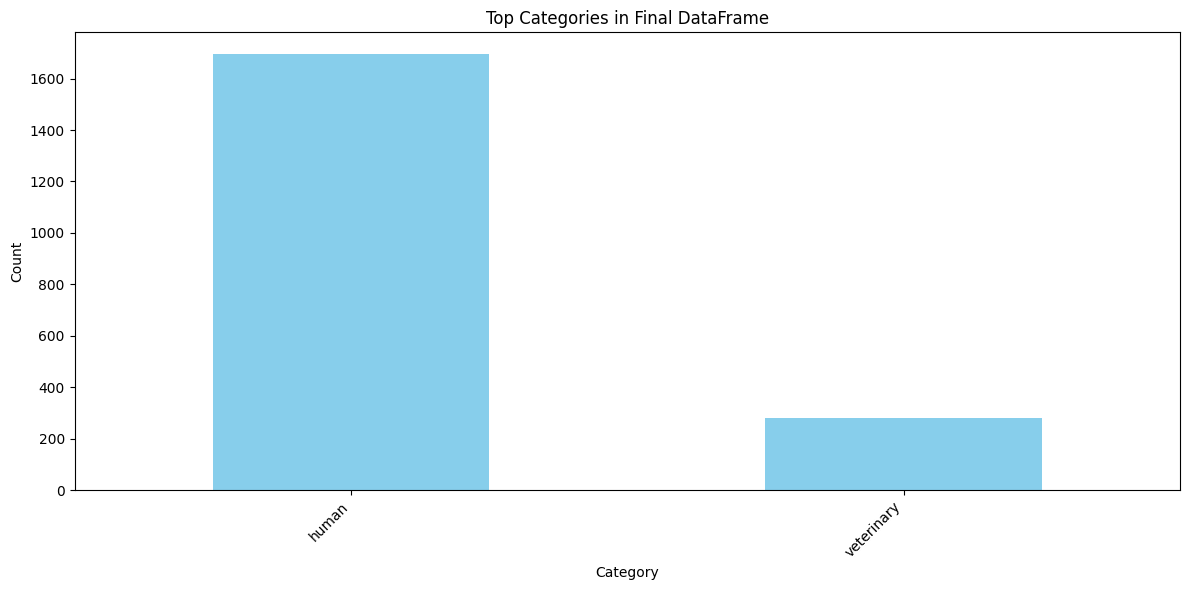

In [ ]:
top_categories = final['category'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top Categories in Final DataFrame')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

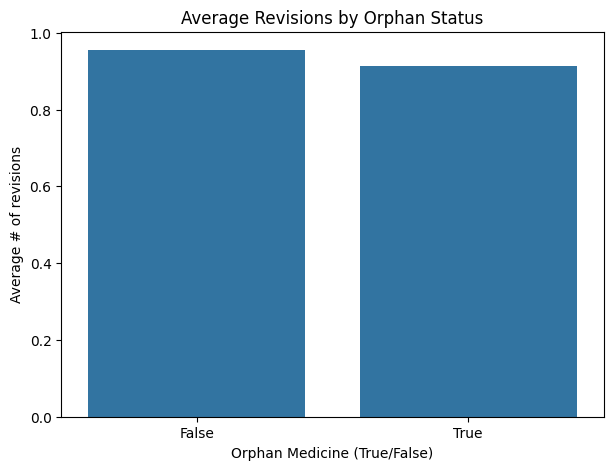

,orphan,avg_revisions,n_medicines
0,False,0.954821,1815
1,True,0.913043,161


In [ ]:
burden = (
    final.groupby('medicine_name_unified')
    .agg(
        n_revisions=('revision_number', 'nunique'),
        orphan=('orphan_medicine', 'max'),
        conditional=('conditional_approval', 'max'),
        monitoring=('additional_monitoring', 'max')
    )
    .reset_index()
)

summary = burden.groupby('orphan').agg(
    avg_revisions=('n_revisions','mean'),
    n_medicines=('medicine_name_unified','count')
).reset_index()

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(data=summary, x='orphan', y='avg_revisions', ax=ax)
ax.set_title("Average Revisions by Orphan Status")
ax.set_xlabel("Orphan Medicine (True/False)")
ax.set_ylabel("Average # of revisions")
plt.show()

summary


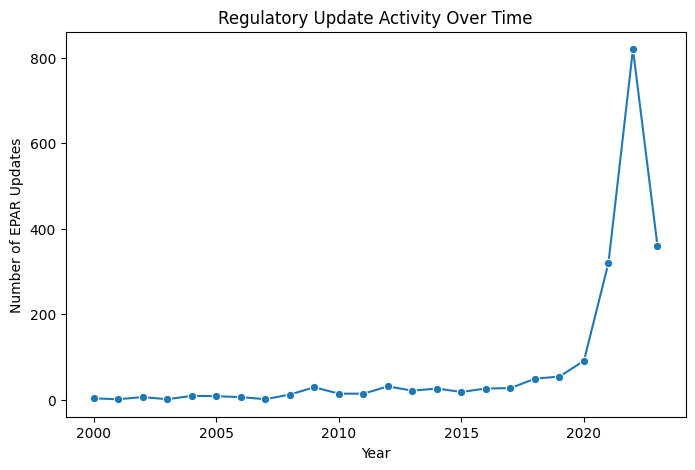

In [ ]:
final['revision_year'] = pd.to_datetime(
    final['revision_date'], errors='coerce'
).dt.year

updates_by_year = (
    final.groupby('revision_year')
    .size()
    .reset_index(name='num_updates')
)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=updates_by_year,
    x='revision_year',
    y='num_updates',
    marker='o'
)
plt.title("Regulatory Update Activity Over Time")
plt.xlabel("Year")
plt.ylabel("Number of EPAR Updates")
plt.show()

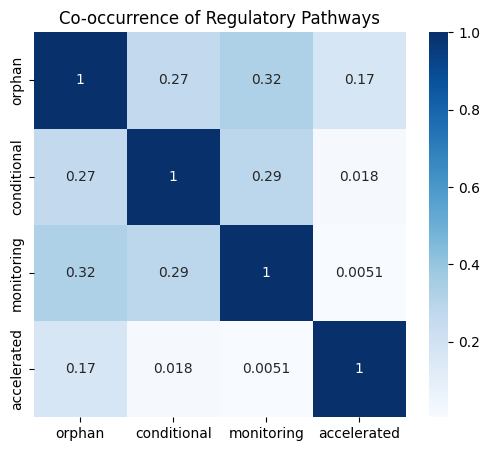

In [ ]:
pathways = (
    final.groupby('medicine_name_unified')
    .agg(
        orphan=('orphan_medicine', 'max'),
        conditional=('conditional_approval', 'max'),
        monitoring=('additional_monitoring', 'max'),
        accelerated=('accelerated_assessment', 'max')
    )
)

# Fix: fill NaNs then convert to 0/1
pathways = pathways.fillna(0).astype(int)

plt.figure(figsize=(6,5))
sns.heatmap(pathways.corr(), annot=True, cmap="Blues")
plt.title("Co-occurrence of Regulatory Pathways")
plt.show()


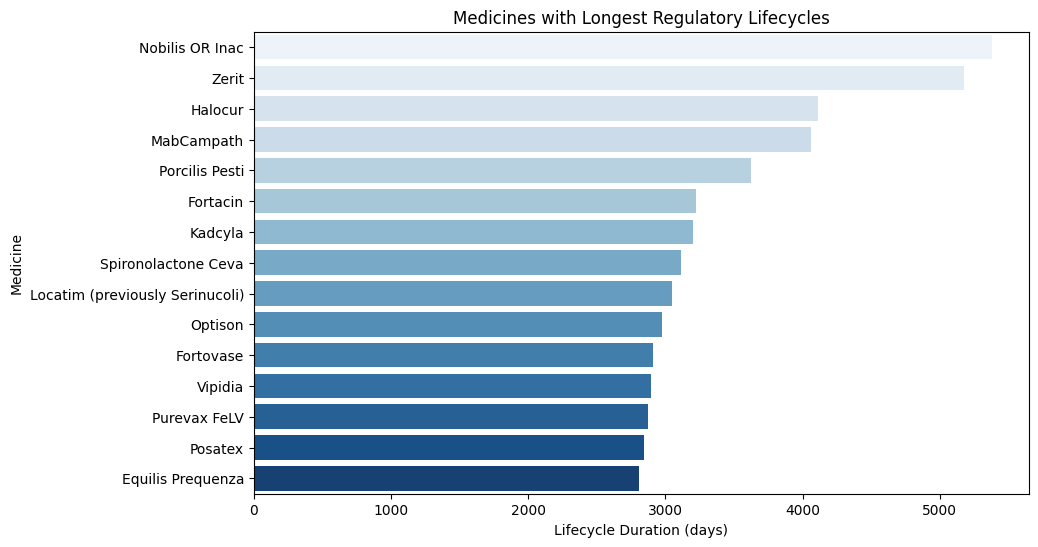

In [ ]:
# Compute lifecycle duration per medicine
lifecycle = (
    final.groupby('medicine_name_unified')
    .agg(
        first_pub=('first_published', 'min'),
        last_rev=('revision_date', 'max')
    )
    .reset_index()
)

lifecycle['first_pub'] = pd.to_datetime(lifecycle['first_pub'], errors='coerce')
lifecycle['last_rev'] = pd.to_datetime(lifecycle['last_rev'], errors='coerce')
lifecycle['lifecycle_days'] = (lifecycle['last_rev'] - lifecycle['first_pub']).dt.days

# Keep only medicines with valid lifecycle info
lifecycle = lifecycle.dropna(subset=['lifecycle_days'])

# Select top 15 medicines with longest lifecycles
top_medicines = lifecycle.sort_values(
    'lifecycle_days', ascending=False
).head(15)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_medicines,
    x='lifecycle_days',
    y='medicine_name_unified',
    hue='medicine_name_unified',
    palette='Blues',
    legend=False
)
plt.title("Medicines with Longest Regulatory Lifecycles")
plt.xlabel("Lifecycle Duration (days)")
plt.ylabel("Medicine")
plt.show()



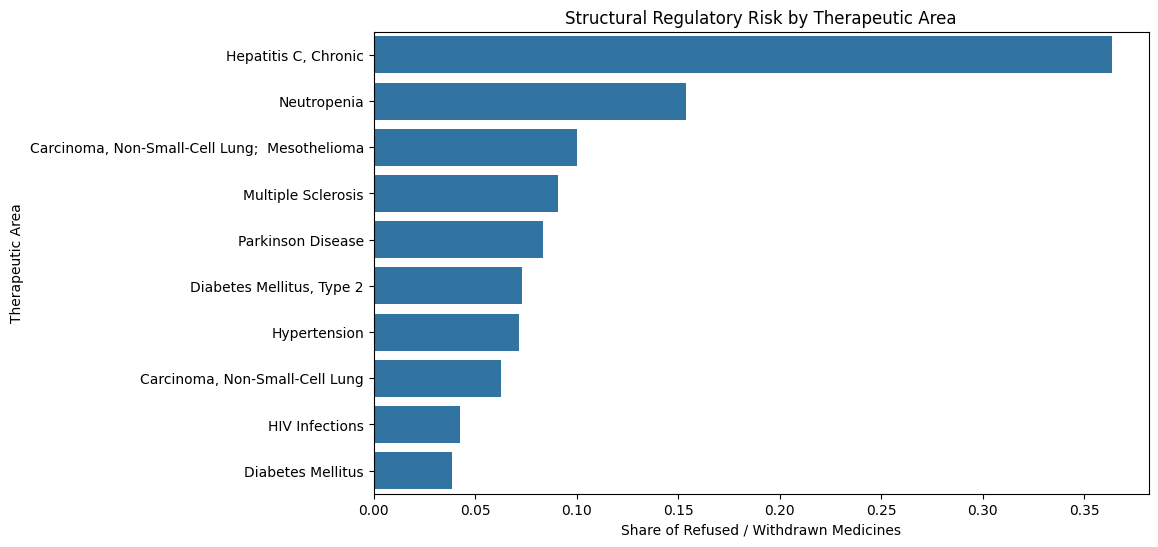

In [ ]:
dev_profile = (
    final.groupby('medicine_name_unified')
    .agg(
        therapeutic_area=('therapeutic_area', 'first'),
        opinion_date=('date_of_opinion', 'min'),
        auth_date=('marketing_authorisation_date', 'min'),
        auth_status=('authorisation_status', 'first')
    )
    .reset_index()
)

# Convert to datetime
dev_profile['opinion_date'] = pd.to_datetime(dev_profile['opinion_date'], errors='coerce')
dev_profile['auth_date'] = pd.to_datetime(dev_profile['auth_date'], errors='coerce')

# Development duration (days)
dev_profile['development_days'] = (
    dev_profile['auth_date'] - dev_profile['opinion_date']
).dt.days

# Keep valid rows
dev_profile = dev_profile.dropna(subset=['development_days', 'therapeutic_area'])
outcomes = (
    dev_profile.assign(
        failed=lambda x: ~x['auth_status'].str.lower().isin(['authorised', 'authorized'])
    )
    .groupby('therapeutic_area')
    .agg(
        total_medicines=('medicine_name_unified', 'count'),
        failures=('failed', 'sum')
    )
    .reset_index()
)

outcomes['failure_rate'] = outcomes['failures'] / outcomes['total_medicines']

outcomes_filtered = outcomes[outcomes['total_medicines'] >= 10].copy()

outcomes_filtered = outcomes_filtered[outcomes_filtered['failure_rate'] > 0]



plt.figure(figsize=(10,6))
sns.barplot(
    data=outcomes_filtered.sort_values('failure_rate', ascending=False),
    x='failure_rate',
    y='therapeutic_area'
)
plt.title("Structural Regulatory Risk by Therapeutic Area")
plt.xlabel("Share of Refused / Withdrawn Medicines")
plt.ylabel("Therapeutic Area")
plt.show()

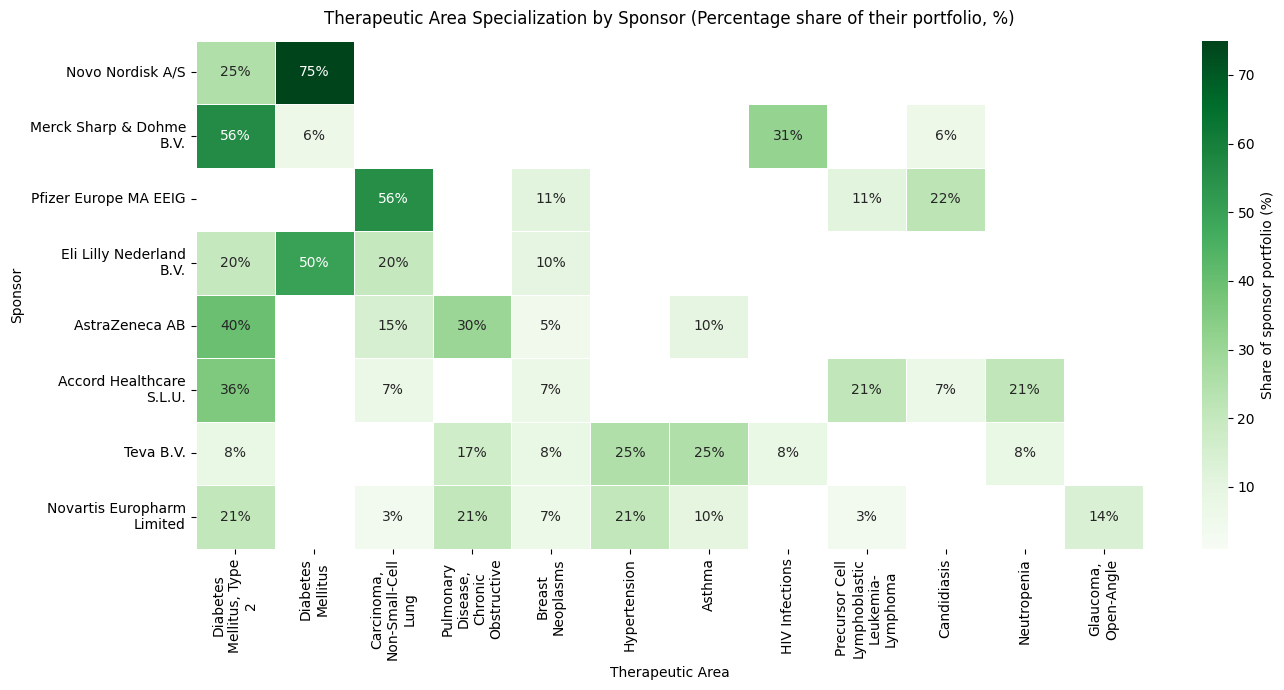

In [ ]:
df = final.dropna(
    subset=["therapeutic_area", "marketing_authorisation_holder_company_name"]
).copy()

df["therapeutic_area_short"] = (
    df["therapeutic_area"]
    .astype(str).str.split(";").str[0].str.strip()
)

TOP_SPONSORS = 8
TOP_AREAS = 12

top_sponsors = df["marketing_authorisation_holder_company_name"].value_counts().head(TOP_SPONSORS).index
df = df[df["marketing_authorisation_holder_company_name"].isin(top_sponsors)]

top_areas = df["therapeutic_area_short"].value_counts().head(TOP_AREAS).index
df = df[df["therapeutic_area_short"].isin(top_areas)]


spec = pd.crosstab(
    df["marketing_authorisation_holder_company_name"],
    df["therapeutic_area_short"],
    normalize="index"
) * 100


spec = spec.loc[spec.sum(axis=1) > 0, spec.sum(axis=0) > 0]


spec = spec.loc[spec.max(axis=1).sort_values(ascending=False).index]
spec = spec[spec.sum(axis=0).sort_values(ascending=False).index]


def shorten(s, width):
    return "\n".join(textwrap.wrap(str(s), width=width))

spec.index = [shorten(x, 22) for x in spec.index]
spec.columns = [shorten(x, 14) for x in spec.columns]


spec_plot = spec.copy()
spec_plot = spec_plot.mask(spec_plot < 1)  # values <1% won’t be shown/colored

annot = spec_plot.apply(
    lambda col: col.map(lambda x: f"{x:.0f}%" if pd.notna(x) else ""))

# plot graph
plt.figure(figsize=(14, 7))
sns.heatmap(
    spec_plot,
    cmap="Greens",
    annot=annot, fmt="",
    linewidths=0.5, linecolor="white",
    cbar_kws={"label": "Share of sponsor portfolio (%)"},
    vmin=1, vmax=np.nanmax(spec.values)
)

plt.title("Therapeutic Area Specialization by Sponsor (Percentage share of their portfolio, %)", pad=12)
plt.xlabel("Therapeutic Area")
plt.ylabel("Sponsor")
plt.tight_layout()
plt.show()